<a href="https://colab.research.google.com/github/rahulkrishnan98/Niki.ai-NLP-Rating-Predictor/blob/master/Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement 
Given reviews in textual format along with features such as App Version code and number. Objective is to allocate a rating from 1 to 5 (Multiclass classification) with 1 being worst to 5 being best. 

1.   Comman problems that are inclusive to this data as well are the NaN values present in multiple feature vectors. More carefully noted, there are more special characters than the normal stopwards that the nltk library can detect. Emojis (\x...) are very definitive in pointing out extremeties. 
2. Through the following lines I hope to capture context via an  Exploratory Data Analysis (EDA) and build upon it via different approaches to tackle the multiclass problem

**Models Used**


1.   Logistic Regression
2.   MultinomialNB
3.   XgBoost

**Vectorization Techniques / Representations Used**
1. TF-IDF
2. Count Vectorizer 





In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.base import BaseEstimator, ClassifierMixin
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from nltk.corpus import stopwords
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import traceback
import pickle
import time
import csv
import sys
import gc
import os
import re
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.models import model_from_json
from keras.utils import np_utils
from keras.preprocessing import sequence, text
from keras.layers import SpatialDropout1D
nltk.download('stopwords')
nltk.download('punkt')

from gensim.models import Word2Vec
import fasttext
import re


punctuation_irritants = ',.-_&%>'
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def metricsSklearn(preds,actuals,model_det):
    print(model_det)
    print(classification_report(actuals, preds))
    cm=confusion_matrix(actuals,preds)
    print "CM is "
    print cm
    plot_confusion_matrix(cm,model_det)

In [0]:
def plot_confusion_matrix(cm,filename,normalized=True, cmap='bone'):
    classes=class_names
    filename="confusion/"+filename+"confusion_matrix.png"
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plt.show()


In [0]:
def LogisticReg(data,label,test_data,test_label,test_data_out):
    model_det="LogisticTF"
    model1=LogisticRegression(C=1.0,solver='lbfgs',multi_class='multinomial')
    model1.fit(data,label)
    preds = list(label_encoder.inverse_transform([int(i) for i in list(model1.predict(test_data))]))
    actuals = label_encoder.inverse_transform(test_label)
    metricsSklearn(preds,actuals,model_det)
    preds = list(label_encoder.inverse_transform([int(i) for i in list(model1.predict(test_data_out))]))
    return preds

In [0]:
def Multinomial(data,label,test_data,test_label):
    model_det="MultinomialNB"
    model=MultinomialNB()
    model.fit(data,label)
    preds=list(label_encoder.inverse_transform([int(i) for i in list(model.predict(test_data))]))
    actuals=label_encoder.inverse_transform(test_label)
    metricsSklearn(preds,actuals,model_det)

In [0]:
def XgBoost(data,label,test_data,test_label,class_count):
    data = data.toarray()
    xg_train = xgb.DMatrix(data, label=label)
    num_round = 10  # number of rounds for boosting
    params = {'booster': 'gbtree', 'max_depth': 10, 'objective': 'multi:softmax', 'eval_metric': 'auc', 'silent': 1,
              'num_class': class_count}
    bst = xgb.train(params, xg_train, num_round)

    xg_test = xgb.DMatrix(test_data.toarray())
    preds = list(label_encoder.inverse_transform([int(i) for i in list(bst.predict(xg_test))]))
    actuals = label_encoder.inverse_transform(test_label)
    model_det='XgBoostCount'
    metricsSklearn(preds,actuals,model_det)

In [0]:
def LogisticRegTest(data,label,test_data):
    model_det="LogisticTF"
    model=LogisticRegression(C=1.0,solver='lbfgs',multi_class='multinomial')
    model.fit(data,label)
    preds = list(label_encoder.inverse_transform([int(i) for i in list(model.predict(test_data))]))
    return model

In [0]:
def clean_sent(sent):
    for irritant in punctuation_irritants:
        sent = sent.replace(irritant, ' ')
    return sent
def tokenize(value, number_required_flag=False):
    overall_value = []
    value = value.lower().decode('utf-8')
    # For each column tokenize into sentences and words
    for sent in sent_tokenize(value):
        sent_data = []
        # The following line is the fastest way to remove punctuations
        sent = clean_sent(sent)
        # The following line removes digits
        if number_required_flag:
            pass
        else:
            sent = re.sub(r'\d+', ' ', sent)
        for word in word_tokenize(sent):
            if word not in stopwords and word != '' and str.isalnum(word.encode('ascii', 'ignore')) and len(word) > 1:
                sent_data.append(word)
            else:
                pass
        overall_value.append(' '.join(sent_data))
    return ' '.join(overall_value).encode('ascii', 'ignore')

In [0]:
df_test=pd.read_csv('test.csv')
df_test=df_test[['Review Text','id']]
df_test=df_test.astype(str)
df_test=df_test.drop_duplicates()
df_test['Review Text']=df_test['Review Text'].map(tokenize)

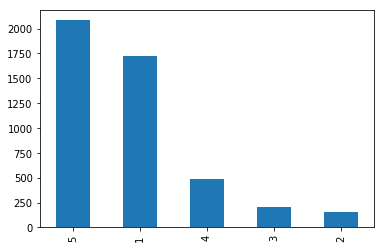

In [0]:
df= pd.read_csv('train.csv')
df= df[['Review Text','Star Rating']]
df=df.astype(str)
df=df.drop_duplicates()
df['Review Text']=df['Review Text'].map(tokenize)

class_count=len(df['Star Rating'].value_counts())
class_names=list(df['Star Rating'].unique())

df['Star Rating'].value_counts().plot.bar()
plt.show()

# Rating Distribution - Class Imbalance


1.   We observe that the extremes are imbalanced in comparison with other classes.
2.   A shortcoming that can be expected here is uneven learning that can lead to inncorrectly classifying classes that are not remotely linked to input feature vector. A clear observation of the same can be found in the confusion matrices attached below in case of class '3'.



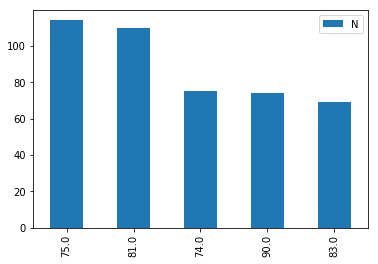

In [0]:
#Which App version has most negative rating
neg=pd.read_csv('train.csv')
neg=neg[neg['Star Rating']==1]
neg=neg['App Version Code'].value_counts()
neg=neg.iloc[:5]
neg.plot.bar()
plt.legend("N", loc="upper right")
plt.show()



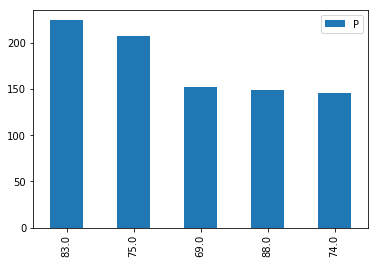

In [0]:
#Which App version has most positive Rating
pos=pd.read_csv('train.csv')
pos=pos[pos['Star Rating']==5]
pos=pos['App Version Code'].value_counts()
pos=pos.iloc[:5]
pos.plot.bar()
plt.legend("P", loc="upper right")
plt.show()

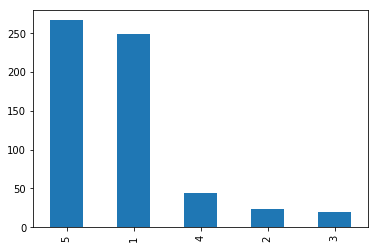

In [0]:
#Given review title exists are they leading to positive or negative comments
rating=pd.read_csv('train.csv')
rating=rating[~rating['Review Title'].isnull()]
rating['Star Rating'].value_counts().plot.bar()

# Inference
Given the user has put in time and effort to give Review Title, the rating tends to be more extreme. That is, either the user has a profound liking or utter disgust. Such extremities can be dealt with seperatly for better accuracy. 

# Approaches 

In [0]:
df_final=pd.concat([df['Review Text'],df_test['Review Text']])

In [0]:
#Label encode for y and split data
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df['Star Rating'])
label_encoded_labels = label_encoder.transform(df['Star Rating'])
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['Review Text'],label_encoded_labels)

In [0]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
tfidf_vec.fit(df_final.to_list())
trn_term_doc = tfidf_vec.transform(train_x)
test_term_doc = tfidf_vec.transform(valid_x)

In [0]:
test_data_out=tfidf_vec.transform(df_test['Review Text'])


In [0]:
#CountVectorised
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 1), stop_words = 'english')
# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(df["Review Text"].to_list())
xtrain_ctv =  ctv.transform(train_x) 
xvalid_ctv = ctv.transform(valid_x)


# Logistic Reg

LogisticTF
              precision    recall  f1-score   support

           1       0.79      0.90      0.84       432
           2       0.00      0.00      0.00        45
           3       0.00      0.00      0.00        45
           4       0.50      0.01      0.01       141
           5       0.71      0.95      0.81       502

   micro avg       0.74      0.74      0.74      1165
   macro avg       0.40      0.37      0.33      1165
weighted avg       0.66      0.74      0.66      1165

CM is 
[[388   0   0   0  44]
 [ 34   0   0   1  10]
 [ 23   0   0   0  22]
 [ 21   0   1   1 118]
 [ 26   0   0   0 476]]


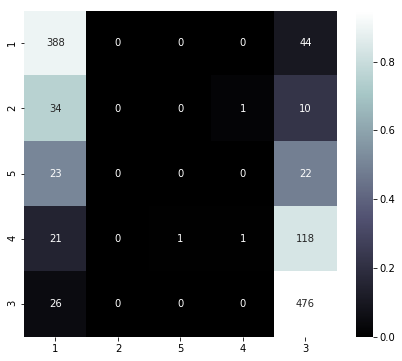

In [0]:
out=LogisticReg(trn_term_doc,train_y,test_term_doc,valid_y,test_data_out)

LogisticTF
              precision    recall  f1-score   support

           1       0.83      0.86      0.84       444
           2       0.17      0.03      0.05        37
           3       0.20      0.04      0.07        47
           4       0.24      0.08      0.12       125
           5       0.73      0.92      0.81       512

   micro avg       0.74      0.74      0.74      1165
   macro avg       0.43      0.39      0.38      1165
weighted avg       0.68      0.74      0.70      1165

CM is 
[[381   4   5   5  49]
 [ 23   1   0   1  12]
 [ 17   1   2  10  17]
 [ 17   0   0  10  98]
 [ 22   0   3  15 472]]


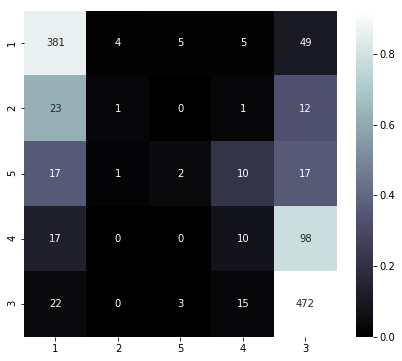

In [0]:
LogisticReg(xtrain_ctv,train_y,xvalid_ctv,valid_y)

# XgBoost

XgBoostCount
              precision    recall  f1-score   support

           1       0.75      0.74      0.75       434
           2       0.00      0.00      0.00        37
           3       0.20      0.02      0.04        52
           4       0.20      0.01      0.03       136
           5       0.64      0.91      0.75       506

   micro avg       0.67      0.67      0.67      1165
   macro avg       0.36      0.34      0.31      1165
weighted avg       0.59      0.67      0.61      1165

CM is 
[[323   3   1   0 107]
 [ 30   0   0   0   7]
 [ 21   0   1   1  29]
 [ 19   1   1   2 113]
 [ 38   1   2   7 458]]


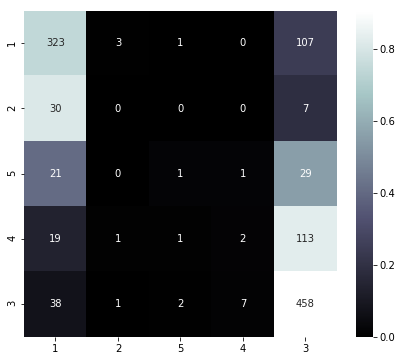

In [0]:
XgBoost(trn_term_doc,train_y,test_term_doc,valid_y,class_count)

XgBoostCount
              precision    recall  f1-score   support

           1       0.79      0.72      0.75       434
           2       0.00      0.00      0.00        37
           3       0.33      0.02      0.04        52
           4       0.71      0.04      0.07       136
           5       0.63      0.94      0.75       506

   micro avg       0.68      0.68      0.68      1165
   macro avg       0.49      0.34      0.32      1165
weighted avg       0.66      0.68      0.62      1165

CM is 
[[311   0   0   0 123]
 [ 25   0   1   0  11]
 [ 19   0   1   0  32]
 [ 12   0   0   5 119]
 [ 27   0   1   2 476]]


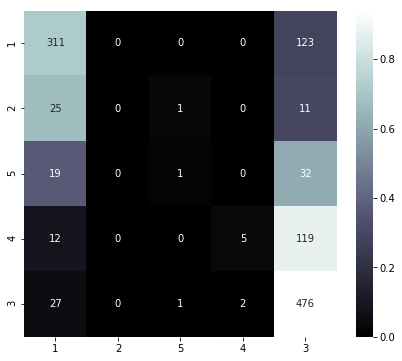

In [0]:
XgBoost(xtrain_ctv,train_y,xvalid_ctv,valid_y,class_count)

# MultinomialNB

MultinomialNB
              precision    recall  f1-score   support

           1       0.79      0.90      0.84       434
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00       136
           5       0.71      0.94      0.81       506

   micro avg       0.74      0.74      0.74      1165
   macro avg       0.30      0.37      0.33      1165
weighted avg       0.60      0.74      0.67      1165

CM is 
[[391   0   0   0  43]
 [ 31   0   0   0   6]
 [ 27   0   0   0  25]
 [ 19   0   0   0 117]
 [ 30   0   0   0 476]]


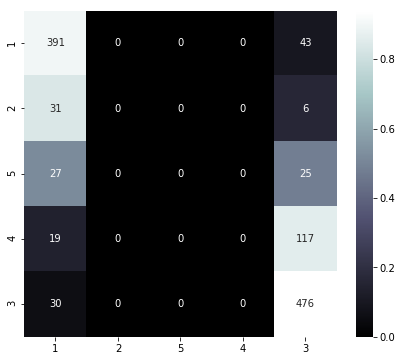

In [0]:
Multinomial(trn_term_doc,train_y,test_term_doc,valid_y)

MultinomialNB
              precision    recall  f1-score   support

           1       0.82      0.89      0.85       444
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        47
           4       0.27      0.02      0.04       125
           5       0.73      0.94      0.82       512

   micro avg       0.76      0.76      0.76      1165
   macro avg       0.36      0.37      0.34      1165
weighted avg       0.66      0.76      0.69      1165

CM is 
[[394   4   4   5  37]
 [ 22   0   1   0  14]
 [ 24   0   0   1  22]
 [ 15   0   0   3 107]
 [ 25   0   2   2 483]]


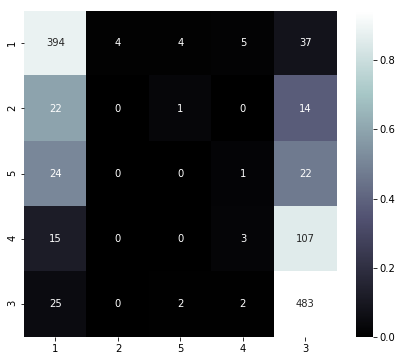

(1165, 4288)


In [0]:
Multinomial(xtrain_ctv,train_y,xvalid_ctv,valid_y)

#Side Hacks to better Metrics


*   It is noted that smilies almost always tend to equate to a high positive review. General intution behind that is, people refrain from investing time in emojis while lamenting about a bad review/ problem they faced.
*  If review title available check sentiment and equate to extremes [1 and 5]. Since they are mostly reflective of the rating and are not subjective like Review Text
*  I am not including it towards calculation of F-measure as they do not tend to be real-world and are mostly local to this review set. 



In [0]:
def is_emoji(s):
    emojis = ["😊","😘","👍","⚡⚡","(y)","😀","👌","🔥"] # add more differentiators here as data progresses
    count = 0
    for emoji in emojis:
        count += s.count(emoji)
        if count > 1:
            return False
    return bool(count)

def nega_emoji(s):
    emojis = ["😡","😢","***","Fake"];
    count=0
    for emoji in emojis:
        count+=s.count(emoji)
        if count >1:
            return False
    return bool(count)

In [0]:
df1=pd.read_csv('train.csv')
a=df1[['Review Text', 'Star Rating']]
inn=a['Review Text'].to_list()
rating=a['Star Rating'].to_list()

count=0
total=0
for i in range(len(inn)):
    inn[i]=str(inn[i])
    if is_emoji(inn[i]):
        total+=1
        if(rating[i]==5):
            count+=1
print float(count)/total


0.833333333333


**The results are as expected, but again such a scenario might not present itself in a general use case, rather even in a larger corpus of the same dataset. Thus I have validated f-measure scores only for more traditional approaches in the above decks.**

# Running it on Test Data
Since the answer mandates only one approach I shall be going ahead with the Logistic Regression on count Vectors. 

In [0]:
first={}
for i in range(len(df_test)):
    first[df_test["id"].iloc[i]]=out[i]
print first
    

In [0]:
df1= pd.read_csv('test.csv')
df1=df1[['Review Text','id']]
id=df1['id'].to_list()

inn=df1['Review Text']
inn=inn.to_list()

#splitting into data for model and data based on emojis
output={}

#overwriting extremes
for i in range(len(inn)):
    inn[i]=str(inn[i])
    if nega_emoji(inn[i]):
        output[id[i]]=1
    elif(is_emoji(inn[i])):
        output[id[i]]=5

    else:
        output[id[i]]=first[id[i]]
print output

In [0]:
wri=[['id','Star Rating']]
for key,value in output.items():
    wri.append([key,value])


myFile = open('submit.csv', 'w')
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(wri)

# Sumbit.csv
All ratings are finally writen to submit.csv
